## 1. Install Required Packages

In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost catboost shap imbalanced-learn pyarrow openpyxl scipy -q

print("✓ All packages installed successfully!")

✓ All packages installed successfully!


'pip' is not recognized as an internal or external command,
operable program or batch file.


## 2. Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import json
import xml.etree.ElementTree as ET
from scipy import stats
from pathlib import Path
import pickle

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report,
    precision_recall_curve, average_precision_score
)
import xgboost as xgb
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE

# Interpretability
import shap

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
%matplotlib inline

C:\Users\huriy\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 3. Preprocessing Pipeline Class

This class handles all preprocessing steps and can be reused for test data

In [3]:
class CreditRiskPreprocessor:
    """
    Enhanced preprocessing pipeline for credit risk data with comprehensive feature engineering.
    Implements target encoding, interaction features, and stability indicators.
    Fits on training data and transforms both train and test data consistently.
    """
    
    def __init__(self, min_samples_for_smoothing=15):
        self.categorical_mappings = {}
        self.group_medians = {}
        self.global_medians = {}
        self.percentiles = {}
        self.label_encoders = {}
        self.features_for_indicators = []
        self.numerical_cols = []
        self.categorical_cols = []
        self.feature_names = []
        
        # Target encoding parameters
        self.target_encodings = {}
        self.global_target_mean = 0.0
        self.min_samples = min_samples_for_smoothing
        self.target_encoding_features = [
            'loan_officer_id', 
            'marketing_campaign', 
            'origination_channel',
            'state',
            'loan_purpose',
            'employment_type'
        ]
    
    def clean_numeric_column(self, series):
        """Clean numeric columns with $, commas, spaces, etc."""
        if series.dtype == 'object':
            cleaned = (
                series.astype(str)
                      .str.replace(r'[$, ]', '', regex=True)
                      .str.strip()
            )
            cleaned = cleaned.replace(['', 'nan', 'NaN', 'NA', 'N/A', 'None', 'null'], np.nan)
            return pd.to_numeric(cleaned, errors='coerce')
        return series
    
    def clean_categorical_column(self, series):
        """Clean categorical columns"""
        if series.dtype == 'object':
            series = series.astype(str).str.strip()
            series = series.str.replace(r'\s+', ' ', regex=True)
            series = series.str.lower()
            series = series.replace(['none', 'null', 'n/a', 'na', 'nan', '', ' ', 'unknown'], np.nan)
        return series
    
    def standardize_categorical_values(self, series):
        """Standardize categorical values"""
        mappings = {
            # Credit card variations
            'cc': 'credit_card',
            'creditcard': 'credit_card',
            'credit card': 'credit_card',
            'credit-card': 'credit_card',

            # Personal loan variations
            'personal': 'personal_loan',
            'personal loan': 'personal_loan',
            'personal-loan': 'personal_loan',
            'pl': 'personal_loan',

            # Auto loan variations
            'auto': 'auto_loan',
            'auto loan': 'auto_loan',
            'car': 'auto_loan',
            'car loan': 'auto_loan',
            'vehicle': 'auto_loan',

            # Mortgage variations
            'mortgage': 'mortgage',
            'home': 'mortgage',
            'home loan': 'mortgage',
            'house': 'mortgage',

            # Education variations
            'education': 'education',
            'student': 'education',
            'student loan': 'education',

            # Yes/No variations
            'yes': 'yes',
            'y': 'yes',
            'true': 'yes',
            'no': 'no',
            'n': 'no',
            'false': 'no',

            # Employment type variations
            'full-time': 'full_time',
            'full time': 'full_time',
            'fulltime': 'full_time',
            'ft': 'full_time',
            'part-time': 'part_time',
            'part time': 'part_time',
            'parttime': 'part_time',
            'pt': 'part_time',
            'self-employed': 'self_employed',
            'self employed': 'self_employed',
            'selfemployed': 'self_employed',
            'self emp':'self_employed',
            'contractor':'contract'
        }
        
        if series.dtype == 'object':
            series = series.map(lambda x: mappings.get(str(x).lower().strip(), x) if pd.notna(x) else x)
        return series
    
    def create_target_encoding(self, df, feature, target_col='default'):
        """
        Create target encoding with smoothing to prevent overfitting.
        Formula: encoded_value = (count × target_mean + min_samples × global_mean) / (count + min_samples)
        """
        # Calculate statistics for each category
        agg = df.groupby(feature)[target_col].agg(['mean', 'count']).reset_index()
        agg.columns = [feature, 'target_mean', 'count']
        
        # Apply smoothing
        agg['encoded_value'] = (
            (agg['count'] * agg['target_mean'] + self.min_samples * self.global_target_mean) /
            (agg['count'] + self.min_samples)
        )
        
        # Store mapping
        encoding_dict = dict(zip(agg[feature], agg['encoded_value']))
        return encoding_dict
    
    def apply_target_encoding(self, df, feature, is_train=True):
        """Apply target encoding to a feature, handling unseen categories in test set."""
        if is_train:
            # For training, use the learned encoding directly
            encoded = df[feature].map(self.target_encodings[feature])
        else:
            # For test set, handle unseen categories
            encoded = df[feature].map(self.target_encodings[feature])
        
        return encoded
    
    def fit(self, df, target_col='default'):
        """
        Fit the preprocessor on training data.
        Learns all transformations needed.
        """
        print("\n" + "="*80)
        print("FITTING ENHANCED PREPROCESSING PIPELINE")
        print("="*80)
        
        df_clean = df.copy()
        
        # Step 1: Clean data
        print("\n[Step 1] Cleaning data...")
        for col in df_clean.select_dtypes(include='object').columns:
            if col not in ['customer_id', 'application_id', 'referral_code', 'account_status_code']:
                df_clean[col] = self.clean_categorical_column(df_clean[col])
                df_clean[col] = self.standardize_categorical_values(df_clean[col])
        
        for col in df_clean.select_dtypes(include='object').columns:
            sample = df_clean[col].dropna().astype(str).head(100)
            if sample.str.contains(r'[$,.]').any() or sample.str.isnumeric().any():
                df_clean[col] = self.clean_numeric_column(df_clean[col])
        
        # Step 2: Identify column types
        print("\n[Step 2] Identifying column types...")
        self.categorical_cols = df_clean.select_dtypes(include=['object']).columns.tolist()
        self.categorical_cols = [c for c in self.categorical_cols if 'id' not in c.lower()]
        
        self.numerical_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
        self.numerical_cols = [c for c in self.numerical_cols 
                              if c not in [target_col, 'customer_id', 'application_id']]
        
        print(f"  Categorical columns: {len(self.categorical_cols)}")
        print(f"  Numerical columns: {len(self.numerical_cols)}")
        
        # Step 3: Store medians for imputation
        print("\n[Step 3] Learning imputation values...")
        for col in self.numerical_cols:
            if col in df_clean.columns:
                self.global_medians[col] = df_clean[col].median()
        
        # Step 4: Learn target encoding
        if target_col in df_clean.columns:
            print("\n[Step 4] Learning target encodings...")
            self.global_target_mean = df_clean[target_col].mean()
            print(f"  Global target mean: {self.global_target_mean:.4f}")
            
            for feature in self.target_encoding_features:
                if feature in df_clean.columns:
                    # Fill missing values before encoding
                    df_clean[feature] = df_clean[feature].fillna('missing')
                    self.target_encodings[feature] = self.create_target_encoding(df_clean, feature, target_col)
                    print(f"  ✓ Encoded {feature}: {len(self.target_encodings[feature])} categories")
        
        print(f"\n✓ Pipeline fitted successfully!")
        return self
    
    def transform(self, df, target_col='default', is_train=True):
        """
        Transform data using fitted parameters with comprehensive feature engineering.
        Works for both train and test data.
        """
        print("\n" + "="*80)
        print(f"TRANSFORMING DATA WITH ENHANCED FEATURES ({'TRAIN' if is_train else 'TEST'})")
        print("="*80)
        
        df_processed = df.copy()
        
        # ========================================================================
        # CRITICAL REQUIREMENT #1: Drop random_noise_1
        # ========================================================================
        print("\n[Critical] Dropping random_noise_1 column...")
        if 'random_noise_1' in df_processed.columns:
            df_processed = df_processed.drop(columns=['random_noise_1'])
            print("  ✓ Removed planted noise column")
        
        # Step 1: Clean data
        print("\n[Step 1] Cleaning data...")
        for col in df_processed.select_dtypes(include='object').columns:
            if col not in ['customer_id', 'application_id', 'referral_code', 'account_status_code']:
                df_processed[col] = self.clean_categorical_column(df_processed[col])
                df_processed[col] = self.standardize_categorical_values(df_processed[col])
        
        for col in df_processed.select_dtypes(include='object').columns:
            sample = df_processed[col].dropna().astype(str).head(100)
            if sample.str.contains(r'[$,.]').any() or sample.str.isnumeric().any():
                df_processed[col] = self.clean_numeric_column(df_processed[col])
        
        # Step 2: Handle categorical missing values
        print("\n[Step 2] Imputing categorical features...")
        for col in self.categorical_cols:
            if col in df_processed.columns and df_processed[col].isna().sum() > 0:
                df_processed[col] = df_processed[col].fillna('missing')
        
        # Step 3: Handle numerical missing values
        print("\n[Step 3] Imputing numerical features...")
        for col in self.numerical_cols:
            if col in df_processed.columns and df_processed[col].isna().sum() > 0:
                # Use global median
                if col in self.global_medians:
                    df_processed[col] = df_processed[col].fillna(self.global_medians[col])
        
        # ========================================================================
        # CRITICAL REQUIREMENT #2: Referral Code Binary Mapping
        # ========================================================================
        print("\n[Step 4] Creating referral_code binary feature...")
        if 'referral_code' in df_processed.columns:
            # has_referral: 1 if referred (not REF0000), 0 if REF0000
            df_processed['has_referral'] = (
                df_processed['referral_code'].astype(str).str.upper() != 'REF0000'
            ).astype(int)
            print("  ✓ Created 'has_referral' binary feature (1=referred, 0=REF0000)")
        
        # ========================================================================
        # FEATURE TRANSFORMATION #3: Application Timing Features
        # ========================================================================
        print("\n[Step 5] Creating application timing features...")
        if 'application_hour' in df_processed.columns:
            # Binary: is_night_application (22-6)
            df_processed['is_night_application'] = (
                ((df_processed['application_hour'] >= 22) | (df_processed['application_hour'] <= 6))
            ).astype(int)
            
            # Binary: is_late_night_application (0-5)
            df_processed['is_late_night_application'] = (
                (df_processed['application_hour'] >= 0) & (df_processed['application_hour'] <= 5)
            ).astype(int)
            
            # Cyclical encoding: preserve hour proximity (e.g., 23 and 0 are close)
            df_processed['application_hour_sin'] = np.sin(2 * np.pi * df_processed['application_hour'] / 24)
            
            print("  ✓ Created is_night_application, is_late_night_application, cyclical encoding")
        
        
        # ========================================================================
        # FEATURE TRANSFORMATION #5: Business Metadata Target Encoding
        # ========================================================================
        print("\n[Step 7] Applying target encoding to business metadata...")
        for feature in self.target_encoding_features:
            if feature in df_processed.columns and feature in self.target_encodings:
                # Fill missing values
                df_processed[feature] = df_processed[feature].fillna('missing')
                # Apply encoding
                df_processed[f'{feature}_encoded'] = self.apply_target_encoding(df_processed, feature, is_train)
                print(f"  ✓ Target-encoded {feature}")
        
        # ========================================================================
        # INTERACTION FEATURES #6: Credit Behavior × Financial Capacity
        # ========================================================================
        print("\n[Step 8] Creating credit behavior × financial capacity interactions...")
        
        # 1. credit_score × debt_to_income_ratio
        if 'credit_score' in df_processed.columns and 'debt_to_income_ratio' in df_processed.columns:
            df_processed['credit_score_x_dti'] = (
                df_processed['credit_score'] * df_processed['debt_to_income_ratio']
            )
                
        # 3. credit_utilization × available_credit
        if 'credit_utilization' in df_processed.columns and 'available_credit' in df_processed.columns:
            df_processed['util_x_avail_credit'] = (
                df_processed['credit_utilization'] * df_processed['available_credit']
            )
        
        # 4. credit_score × credit_utilization (good score + high utilization = stress)
        if 'credit_score' in df_processed.columns and 'credit_utilization' in df_processed.columns:
            df_processed['credit_score_x_util'] = (
                df_processed['credit_score'] * df_processed['credit_utilization']
            )
        
        print("  ✓ Created 4 credit behavior × financial capacity features")
        
        # ========================================================================
        # INTERACTION FEATURES #7: Loan Characteristics × Customer Profile
        # ========================================================================
        print("\n[Step 9] Creating loan characteristics × customer profile interactions...")
        
        # 1. interest_rate × credit_score (high rate + good score = unusual, risky)
        if 'interest_rate' in df_processed.columns and 'credit_score' in df_processed.columns:
            df_processed['rate_x_credit_score'] = (
                df_processed['interest_rate'] * df_processed['credit_score']
            )
        
        # 2. loan_term × age (long term for young borrower)
        if 'loan_term' in df_processed.columns and 'age' in df_processed.columns:
            df_processed['loan_term_x_age'] = (
                df_processed['loan_term'] * df_processed['age']
            )
        
        # 3. loan_amount / credit_score (affordability vs creditworthiness)
        if 'loan_amount' in df_processed.columns and 'credit_score' in df_processed.columns:
            df_processed['loan_per_credit_score'] = (
                df_processed['loan_amount'] / df_processed['credit_score'].replace(0, np.nan)
            ).fillna(0)
        
        # 4. monthly_payment / monthly_income (verify against existing payment_to_income_ratio)
        if 'monthly_payment' in df_processed.columns and 'monthly_income' in df_processed.columns:
            if 'payment_to_income_ratio' not in df_processed.columns:
                df_processed['payment_to_income_ratio'] = (
                    df_processed['monthly_payment'] / df_processed['monthly_income'].replace(0, np.nan)
                ).fillna(0).clip(0, 1)
        
        print("  ✓ Created 4 loan characteristics × customer profile features")
        
        # ========================================================================
        # INTERACTION FEATURES #8: Regional Context × Personal Finances
        # ========================================================================
        print("\n[Step 10] Creating regional context × personal finances interactions...")
        
        # 1. annual_income / regional_median_income (above/below regional average)
        if 'annual_income' in df_processed.columns and 'regional_median_income' in df_processed.columns:
            df_processed['income_vs_regional'] = (
                df_processed['annual_income'] / df_processed['regional_median_income'].replace(0, np.nan)
            ).fillna(1.0)
        
        # 2. monthly_payment / regional_median_rent (relative burden)
        if 'monthly_payment' in df_processed.columns and 'regional_median_rent' in df_processed.columns:
            df_processed['payment_vs_regional_rent'] = (
                df_processed['monthly_payment'] / df_processed['regional_median_rent'].replace(0, np.nan)
            ).fillna(0)
        
        print("  ✓ Created 3 regional context × personal finances features")
        
        # ========================================================================
        # DERIVED FEATURES #9: Financial Stress Indicators
        # ========================================================================
        print("\n[Step 11] Creating financial stress indicators...")
        
        # 1. debt_velocity: monthly inquiry rate
        if 'num_inquiries_6mo' in df_processed.columns:
            df_processed['debt_velocity'] = df_processed['num_inquiries_6mo'] / 6.0
        
        # 2. credit_seeking_intensity: recent inquiries per account
        if 'recent_inquiry_count' in df_processed.columns and 'num_credit_accounts' in df_processed.columns:
            df_processed['credit_seeking_intensity'] = (
                df_processed['recent_inquiry_count'] / df_processed['num_credit_accounts'].replace(0, np.nan)
            ).fillna(0)
        
        # 3. collection_to_accounts_ratio
        if 'num_collections' in df_processed.columns and 'num_credit_accounts' in df_processed.columns:
            df_processed['collection_to_accounts'] = (
                df_processed['num_collections'] / df_processed['num_credit_accounts'].replace(0, np.nan)
            ).fillna(0)
        
        # 4. delinquency_recency_risk
        if 'num_delinquencies_2yrs' in df_processed.columns and 'oldest_account_age_months' in df_processed.columns:
            df_processed['delinquency_recency_risk'] = (
                df_processed['num_delinquencies_2yrs'] * 
                (1.0 / df_processed['oldest_account_age_months'].replace(0, np.nan))
            ).fillna(0)
        
        print("  ✓ Created 4 financial stress indicators")
        
        # ========================================================================
        # DERIVED FEATURES #10: Stability Indicators
        # ========================================================================
        print("\n[Step 12] Creating stability indicators...")
        
        # 1. credit_maturity: credit history as % of life
        if 'oldest_credit_line_age' in df_processed.columns and 'age' in df_processed.columns:
            df_processed['credit_maturity'] = (
                df_processed['oldest_credit_line_age'] / df_processed['age'].replace(0, np.nan)
            ).fillna(0).clip(0, 1)
        
        # 2. employment_stability
        if 'employment_length' in df_processed.columns and 'age' in df_processed.columns:
            df_processed['employment_stability'] = (
                df_processed['employment_length'] / df_processed['age'].replace(0, np.nan)
            ).fillna(0).clip(0, 1)
                
        # 4. account_tenure_ratio
        if 'oldest_account_age_months' in df_processed.columns and 'oldest_credit_line_age' in df_processed.columns:
            df_processed['account_tenure_ratio'] = (
                df_processed['oldest_account_age_months'] / 
                (df_processed['oldest_credit_line_age'] * 12).replace(0, np.nan)
            ).fillna(0).clip(0, 1)
        
        print("  ✓ Created 4 stability indicators")
        
        # ========================================================================
        # DERIVED FEATURES #11: Credit Sophistication
        # ========================================================================
        print("\n[Step 13] Creating credit sophistication features...")
        
        # 1. credit_depth
        if 'num_credit_accounts' in df_processed.columns and 'oldest_credit_line_age' in df_processed.columns:
            df_processed['credit_depth'] = (
                df_processed['num_credit_accounts'] * df_processed['oldest_credit_line_age']
            )
        
        # 2. available_credit_per_account
        if 'available_credit' in df_processed.columns and 'num_credit_accounts' in df_processed.columns:
            df_processed['avail_credit_per_account'] = (
                df_processed['available_credit'] / df_processed['num_credit_accounts'].replace(0, np.nan)
            ).fillna(0)
        
        # 3. credit_limit_to_income
        if 'total_credit_limit' in df_processed.columns and 'annual_income' in df_processed.columns:
            df_processed['credit_limit_to_income'] = (
                df_processed['total_credit_limit'] / df_processed['annual_income'].replace(0, np.nan)
            ).fillna(0)
        
        print("  ✓ Created 3 credit sophistication features")
        
        # ========================================================================
        # ORIGINAL FEATURES: Keep existing feature engineering
        # ========================================================================
        print("\n[Step 14] Applying original feature transformations...")
        
        # Log transformations
        for col in ['annual_income', 'monthly_income', 'loan_amount', 'total_credit_limit']:
            if col in df_processed.columns:
                df_processed[f'{col}_log'] = np.log1p(df_processed[col])
        
        # Square root transformations
        for col in ['num_delinquencies_2yrs', 'num_inquiries_6mo', 'num_credit_accounts']:
            if col in df_processed.columns:
                df_processed[f'{col}_sqrt'] = np.sqrt(df_processed[col])
        
        # Credit utilization (recalculate if needed)
        if 'credit_utilization' not in df_processed.columns:
            if 'total_credit_limit' in df_processed.columns and 'credit_usage_amount' in df_processed.columns:
                df_processed['credit_utilization'] = (
                    df_processed['credit_usage_amount'] / df_processed['total_credit_limit'].replace(0, np.nan)
                ).fillna(0).clip(0, 1)
        
        # Debt-to-income ratio (recalculate if needed)
        if 'debt_to_income_ratio' not in df_processed.columns:
            if 'existing_monthly_debt' in df_processed.columns and 'monthly_income' in df_processed.columns:
                df_processed['debt_to_income_ratio'] = (
                    df_processed['existing_monthly_debt'] / df_processed['monthly_income'].replace(0, np.nan)
                ).fillna(0).clip(0, 2)
        
        # Payment burden
        if 'payment_burden' not in df_processed.columns:
            if 'monthly_payment' in df_processed.columns and 'monthly_income' in df_processed.columns:
                df_processed['payment_burden'] = (
                    df_processed['monthly_payment'] / df_processed['monthly_income'].replace(0, np.nan)
                ).fillna(0).clip(0, 1)
        
        # Loan-to-income ratio
        if 'loan_to_income_ratio' not in df_processed.columns:
            if 'loan_amount' in df_processed.columns and 'annual_income' in df_processed.columns:
                df_processed['loan_to_income_ratio'] = (
                    df_processed['loan_amount'] / df_processed['annual_income'].replace(0, np.nan)
                ).fillna(0).clip(0, 5)
        
        # Credit age
        if 'credit_age_years' not in df_processed.columns:
            if 'oldest_account_age_months' in df_processed.columns:
                df_processed['credit_age_years'] = df_processed['oldest_account_age_months'] / 12
        
        # Average credit per account
        if 'avg_credit_per_account' not in df_processed.columns:
            if 'total_credit_limit' in df_processed.columns and 'num_credit_accounts' in df_processed.columns:
                df_processed['avg_credit_per_account'] = (
                    df_processed['total_credit_limit'] / df_processed['num_credit_accounts'].replace(0, np.nan)
                ).fillna(0)
        
        # Credit score bins
        if 'credit_score' in df_processed.columns:
            df_processed['credit_score_bin'] = pd.cut(
                df_processed['credit_score'],
                bins=[0, 580, 670, 740, 800, 850],
                labels=['poor', 'fair', 'good', 'very_good', 'excellent']
            )
        
        # Age groups
        if 'age' in df_processed.columns:
            df_processed['age_group'] = pd.cut(
                df_processed['age'],
                bins=[0, 25, 35, 45, 55, 65, 100],
                labels=['18-25', '26-35', '36-45', '46-55', '56-65', '65+']
            )
        
        # Income level
        if 'annual_income' in df_processed.columns:
            try:
                df_processed['income_level'] = pd.qcut(
                    df_processed['annual_income'],
                    q=4,
                    labels=['low', 'medium', 'high', 'very_high'],
                    duplicates='drop'
                )
            except:
                pass
        
        # Binary flags
        if 'num_delinquencies_2yrs' in df_processed.columns:
            df_processed['has_delinquencies'] = (df_processed['num_delinquencies_2yrs'] > 0).astype(int)
        
        if 'num_inquiries_6mo' in df_processed.columns:
            df_processed['has_recent_inquiries'] = (df_processed['num_inquiries_6mo'] > 0).astype(int)
        
        print(f"\n✓ Transformation complete!")
        print(f"  Final shape: {df_processed.shape}")
        
        # Feature engineering summary
        print(f"\n" + "="*80)
        print("FEATURE ENGINEERING SUMMARY")
        print("="*80)
        print(f"  Total engineered features:  ~40+ new features")
        print("="*80)
        
        return df_processed
    
    def fit_transform(self, df, target_col='default'):
        """Fit and transform in one step"""
        self.fit(df, target_col)
        return self.transform(df, target_col, is_train=True)

print("✓ Enhanced CreditRiskPreprocessor class defined with comprehensive feature engineering!")

✓ Enhanced CreditRiskPreprocessor class defined with comprehensive feature engineering!


## 4. Load and Merge Data

In [4]:
try:
    print("\n[1/6] Loading application_metadata.csv...")
    application_metadata = pd.read_csv('application_metadata.csv')
    print(f"   Shape: {application_metadata.shape}")

    print("\n[2/6] Loading demographics.csv...")
    demographics = pd.read_csv('demographics.csv')
    print(f"   Shape: {demographics.shape}")

    print("\n[3/6] Loading credit_history.parquet...")
    credit_history = pd.read_parquet('credit_history.parquet')
    print(f"   Shape: {credit_history.shape}")

    print("\n[4/6] Loading financial_ratios.jsonl...")
    financial_ratios_list = []
    with open('financial_ratios.jsonl', 'r') as f:
        for line in f:
            financial_ratios_list.append(json.loads(line))
    financial_ratios = pd.DataFrame(financial_ratios_list)
    print(f"   Shape: {financial_ratios.shape}")

    print("\n[5/6] Loading geographic_data.xml...")
    tree = ET.parse('geographic_data.xml')
    root = tree.getroot()
    geo_data = []
    for record in root:
        record_dict = {}
        for child in record:
            record_dict[child.tag] = child.text
        geo_data.append(record_dict)
    geographic_data = pd.DataFrame(geo_data)
    print(f"   Shape: {geographic_data.shape}")

    print("\n[6/6] Loading loan_details.xlsx...")
    loan_details = pd.read_excel('loan_details.xlsx')
    print(f"   Shape: {loan_details.shape}")

    print("\n✓ All data files loaded successfully!")

except Exception as e:
    print(f"\nError loading data: {e}")
    raise


[1/6] Loading application_metadata.csv...
   Shape: (89999, 14)

[2/6] Loading demographics.csv...
   Shape: (89999, 8)

[3/6] Loading credit_history.parquet...
   Shape: (89999, 12)

[4/6] Loading financial_ratios.jsonl...
   Shape: (89999, 16)

[5/6] Loading geographic_data.xml...
   Shape: (89999, 8)

[6/6] Loading loan_details.xlsx...
   Shape: (89999, 10)

✓ All data files loaded successfully!


In [5]:
# Standardize customer ID columns
id_mapping = {
    'customer_ref': 'customer_id',
    'cust_id': 'customer_id',
    'customer_number': 'customer_id',
    'cust_num': 'customer_id',
    'id': 'customer_id'
}

datasets = {
    'application_metadata': application_metadata,
    'demographics': demographics,
    'credit_history': credit_history,
    'financial_ratios': financial_ratios,
    'geographic_data': geographic_data,
    'loan_details': loan_details
}

# Rename columns
for name, dataset in datasets.items():
    for old_name, new_name in id_mapping.items():
        if old_name in dataset.columns:
            dataset.rename(columns={old_name: new_name}, inplace=True)

# Convert to string
for name, dataset in datasets.items():
    if 'customer_id' in dataset.columns:
        dataset['customer_id'] = dataset['customer_id'].astype(str)

print("✓ Standardized customer ID columns")

# Merge all datasets
df = application_metadata.copy()
print(f"\nBase dataset: {df.shape}")

for name, dataset in [('demographics', demographics),
                       ('credit_history', credit_history),
                       ('financial_ratios', financial_ratios),
                       ('geographic_data', geographic_data),
                       ('loan_details', loan_details)]:
    common_cols = list(set(df.columns) & set(dataset.columns))
    if common_cols:
        key = common_cols[0]
        print(f"Merging {name} on '{key}'...")
        df = df.merge(dataset, on=key, how='left', suffixes=('', f'_{name}'))
        print(f"  New shape: {df.shape}")

print(f"\n✓ Final merged dataset: {df.shape}")

# Check target variable
if 'default' in df.columns:
    print(f"\n✓ Target 'default' found")
    print(f"Value counts:\n{df['default'].value_counts()}")
else:
    print("\n⚠ WARNING: 'default' column not found!")

✓ Standardized customer ID columns

Base dataset: (89999, 14)
Merging demographics on 'customer_id'...
  New shape: (89999, 21)
Merging credit_history on 'customer_id'...
  New shape: (89999, 32)
Merging financial_ratios on 'customer_id'...
  New shape: (89999, 47)
Merging geographic_data on 'customer_id'...
  New shape: (89999, 54)
Merging loan_details on 'customer_id'...
  New shape: (89999, 63)

✓ Final merged dataset: (89999, 63)

✓ Target 'default' found
Value counts:
default
0    85405
1     4594
Name: count, dtype: int64


## 5. Apply Preprocessing Pipeline

In [6]:
# Initialize and fit pipeline
preprocessor = CreditRiskPreprocessor()

# Fit and transform training data
df_processed = preprocessor.fit_transform(df, target_col='default')

print(f"\n" + "="*80)
print("PREPROCESSING COMPLETE!")
print("="*80)
print(f"\nProcessed data shape: {df_processed.shape}")
print(f"Features: {df_processed.shape[1]}")


FITTING ENHANCED PREPROCESSING PIPELINE

[Step 1] Cleaning data...

[Step 2] Identifying column types...
  Categorical columns: 11
  Numerical columns: 49

[Step 3] Learning imputation values...

[Step 4] Learning target encodings...
  Global target mean: 0.0510
  ✓ Encoded loan_officer_id: 86 categories
  ✓ Encoded marketing_campaign: 26 categories
  ✓ Encoded origination_channel: 4 categories
  ✓ Encoded state: 20 categories
  ✓ Encoded loan_purpose: 8 categories
  ✓ Encoded employment_type: 4 categories

✓ Pipeline fitted successfully!

TRANSFORMING DATA WITH ENHANCED FEATURES (TRAIN)

[Critical] Dropping random_noise_1 column...
  ✓ Removed planted noise column

[Step 1] Cleaning data...

[Step 2] Imputing categorical features...

[Step 3] Imputing numerical features...

[Step 4] Creating referral_code binary feature...
  ✓ Created 'has_referral' binary feature (1=referred, 0=REF0000)

[Step 5] Creating application timing features...
  ✓ Created is_night_application, is_late_night

## 6. Prepare Data for Modeling

In [7]:
# Separate target
y = df_processed['default'].copy()

# Drop target and ID columns
id_cols = ['customer_id', 'application_id']
cols_to_drop = ['default'] + [col for col in id_cols if col in df_processed.columns]
X = df_processed.drop(columns=cols_to_drop, errors='ignore')

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Handle categorical variables
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()

print(f"\nCategorical features: {len(categorical_cols)}")
print(f"Numerical features: {len(numerical_cols)}")

# Encode categorical variables
label_encoders = {}
if len(categorical_cols) > 0:
    print(f"\nEncoding categorical variables...")
    for col in categorical_cols:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
        label_encoders[col] = le
    print(f"  ✓ Encoded {len(categorical_cols)} categorical columns")

# Handle any remaining missing/inf values
X = X.fillna(0)
X = X.replace([np.inf, -np.inf], 0)

print(f"\n✓ Data preparation complete!")
print(f"Final feature matrix shape: {X.shape}")


Features shape: (89999, 103)
Target shape: (89999,)

Categorical features: 14
Numerical features: 89

Encoding categorical variables...
  ✓ Encoded 14 categorical columns

✓ Data preparation complete!
Final feature matrix shape: (89999, 103)


## 7. Train-Test Split & Scaling

In [8]:
print("\n" + "="*80)
print("SECTION 4: TRAIN-TEST SPLIT")
print("="*80)


# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

print(f"\nTrain target distribution:")
print(y_train.value_counts(normalize=True))

print(f"\nTest target distribution:")
print(y_test.value_counts(normalize=True))

# Scale features
print(f"\nScaling features...")
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X.columns,
    index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X.columns,
    index=X_test.index
)

print("  ✓ Scaling complete!")


SECTION 4: TRAIN-TEST SPLIT

Train set: (71999, 103)
Test set: (18000, 103)

Train target distribution:
default
0    0.948958
1    0.051042
Name: proportion, dtype: float64

Test target distribution:
default
0    0.948944
1    0.051056
Name: proportion, dtype: float64

Scaling features...
  ✓ Scaling complete!


In [9]:
selected_features = X_train.columns

## 8. MODEL TRAINING

In [10]:
print("\n" + "="*80)
print("SECTION 5: MODEL TRAINING")
print("="*80)
models = {}

# 3. XGBoost (uses scaled data)
print("\n[1/2] Training XGBoost...")
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
xgb_model = xgb.XGBClassifier(
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=8,
    min_child_weight=10,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    gamma=1,
    random_state=42,
    tree_method='gpu_hist',
    eval_metric='auc'
)
xgb_model.fit(X_train_scaled, y_train)
models['XGBoost'] = xgb_model
print("  ✓ Complete")

# 4. CatBoost (uses unscaled data with categorical features)
print("\n[2/2] Training CatBoost...")

cat_feature_indices = [X_train.columns.get_loc(col) for col in categorical_cols if col in X_train.columns]

print(f"  → Using {len(cat_feature_indices)} categorical features: {[X_train.columns[i] for i in cat_feature_indices]}")

cat_model = CatBoostClassifier(
    iterations=1000,              
    learning_rate=0.03,           
    depth=8,                      
    l2_leaf_reg=5,                
    min_data_in_leaf=20,          
    border_count=128,
    auto_class_weights='Balanced',
    cat_features=cat_feature_indices,
    task_type='GPU',
    random_state=42,
    verbose=0
)

# Fit on unscaled data (CatBoost handles scaling internally)
cat_model.fit(X_train, y_train)
models['CatBoost'] = cat_model
print("  ✓ Complete")

print("\n" + "="*80)
print("✓ ALL MODELS TRAINED SUCCESSFULLY!")
print("="*80)


SECTION 5: MODEL TRAINING

[1/2] Training XGBoost...
  ✓ Complete

[2/2] Training CatBoost...
  → Using 14 categorical features: ['preferred_contact', 'referral_code', 'account_status_code', 'employment_type', 'education', 'marital_status', 'state', 'loan_type', 'loan_purpose', 'origination_channel', 'marketing_campaign', 'credit_score_bin', 'age_group', 'income_level']
  ✓ Complete

✓ ALL MODELS TRAINED SUCCESSFULLY!


## 9. Model Evaluation

In [11]:
results = []
for name, model in models.items():
    print(f"\n--- Evaluating {name} ---")
    
    # Use appropriate data for each model
    if name == 'CatBoost':
        X_eval = X_test  # CatBoost uses unscaled data
    else:
        X_eval = X_test_scaled  # XGBoost uses scaled data
    
    # Predictions
    y_pred = model.predict(X_eval)
    y_pred_proba = model.predict_proba(X_eval)[:, 1]
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    print(pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)))
    print("_______________________________________________")
    print(f"  ROC-AUC:   {roc_auc:.4f}")
    
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    })

# Results comparison
results_df = pd.DataFrame(results).sort_values('ROC-AUC', ascending=False)
print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)
print(results_df.to_string(index=False))

# Select best model
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]
print(f"\n{'='*80}")
print(f"BEST MODEL: {best_model_name}")
print(f"ROC-AUC: {results_df.iloc[0]['ROC-AUC']:.4f}")
print(f"{'='*80}")


--- Evaluating XGBoost ---
                      0           1  accuracy     macro avg  weighted avg
precision      0.962213    0.287356  0.926333      0.624785      0.927758
recall         0.960073    0.299238  0.926333      0.629655      0.926333
f1-score       0.961142    0.293177  0.926333      0.627159      0.927038
support    17081.000000  919.000000  0.926333  18000.000000  18000.000000
_______________________________________________
  ROC-AUC:   0.7835

--- Evaluating CatBoost ---
                      0           1  accuracy     macro avg  weighted avg
precision      0.969674    0.213235  0.883944      0.591455      0.931054
recall         0.906036    0.473341  0.883944      0.689688      0.883944
f1-score       0.936776    0.294018  0.883944      0.615397      0.903959
support    17081.000000  919.000000  0.883944  18000.000000  18000.000000
_______________________________________________
  ROC-AUC:   0.7966

MODEL COMPARISON
   Model  Accuracy  Precision   Recall  F1-Score 


SECTION A: THRESHOLD OPTIMIZATION

Optimizing threshold for XGBoost...
  Optimal Threshold: 0.430
  F1-Score: 0.2990
  Precision: 0.2566
  Recall: 0.3580

Optimizing threshold for CatBoost...
  Optimal Threshold: 0.550
  F1-Score: 0.3066
  Precision: 0.2376
  Recall: 0.4320

THRESHOLD OPTIMIZATION RESULTS
   Model  Optimal_Threshold  F1_Score  Precision   Recall  Accuracy
CatBoost               0.55  0.306564   0.237582 0.431991  0.900222
 XGBoost               0.43  0.298955   0.256630 0.357998  0.914278


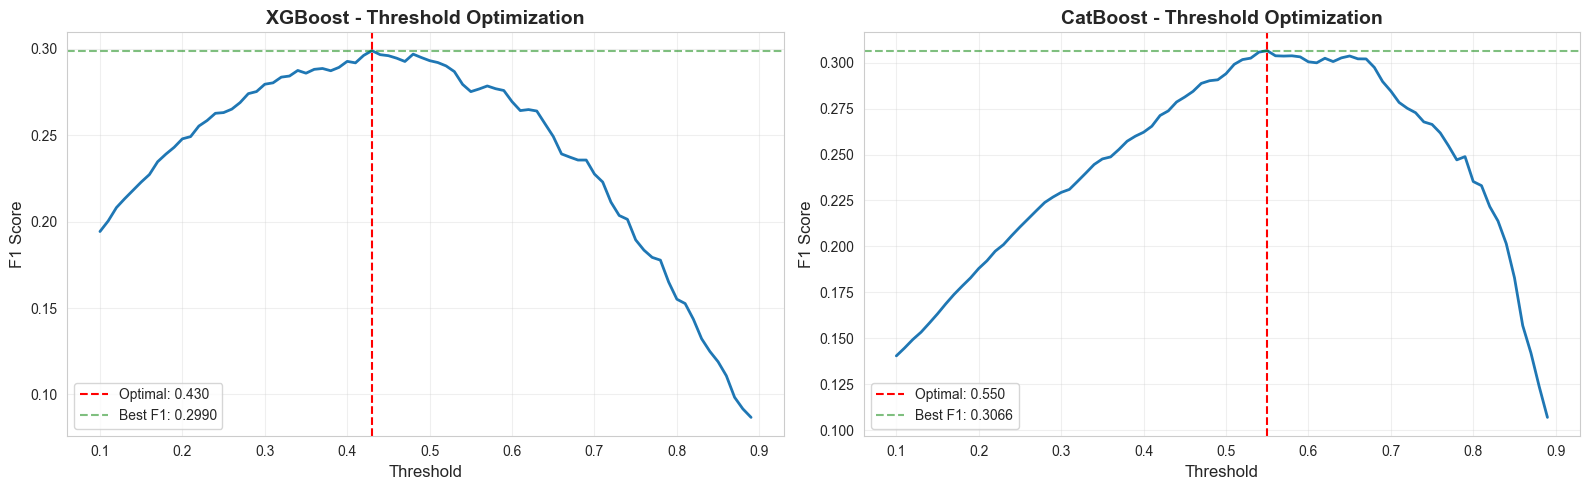


✓ Best model after threshold optimization: CatBoost
✓ Optimal threshold: 0.550
✓ F1 Score: 0.3066


In [12]:
from sklearn.metrics import f1_score

def find_optimal_threshold(model, X_val, y_val, model_name):
    """
    Find optimal probability threshold for F1 score
    """
    y_proba = model.predict_proba(X_val)[:, 1]
    
    # Test thresholds from 0.1 to 0.9
    thresholds = np.arange(0.1, 0.9, 0.01)
    f1_scores = []
    
    for threshold in thresholds:
        y_pred_thresh = (y_proba >= threshold).astype(int)
        f1 = f1_score(y_val, y_pred_thresh, zero_division=0)
        f1_scores.append(f1)
    
    # Find best threshold
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]
    
    # Calculate metrics at optimal threshold
    y_pred_optimal = (y_proba >= best_threshold).astype(int)
    
    return {
        'model': model_name,
        'optimal_threshold': best_threshold,
        'f1_score': best_f1,
        'precision': precision_score(y_val, y_pred_optimal, zero_division=0),
        'recall': recall_score(y_val, y_pred_optimal, zero_division=0),
        'accuracy': accuracy_score(y_val, y_pred_optimal),
        'thresholds': thresholds,
        'f1_scores': f1_scores
    }

print("\n" + "="*80)
print("SECTION A: THRESHOLD OPTIMIZATION")
print("="*80)

threshold_results = []
for name, model in models.items():
    print(f"\nOptimizing threshold for {name}...")
    
    # Use appropriate data for each model
    if name == 'CatBoost':
        X_eval = X_test  # CatBoost uses unscaled data
    else:
        X_eval = X_test_scaled  # XGBoost uses scaled data
    
    result = find_optimal_threshold(model, X_eval, y_test, name)
    threshold_results.append(result)
    
    print(f"  Optimal Threshold: {result['optimal_threshold']:.3f}")
    print(f"  F1-Score: {result['f1_score']:.4f}")
    print(f"  Precision: {result['precision']:.4f}")
    print(f"  Recall: {result['recall']:.4f}")

# Compare with original results
threshold_df = pd.DataFrame([{
    'Model': r['model'],
    'Optimal_Threshold': r['optimal_threshold'],
    'F1_Score': r['f1_score'],
    'Precision': r['precision'],
    'Recall': r['recall'],
    'Accuracy': r['accuracy']
} for r in threshold_results]).sort_values('F1_Score', ascending=False)

print("\n" + "="*80)
print("THRESHOLD OPTIMIZATION RESULTS")
print("="*80)
print(threshold_df.to_string(index=False))

# Visualize threshold vs F1 score (for 2 models)
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

for idx, result in enumerate(threshold_results):
    axes[idx].plot(result['thresholds'], result['f1_scores'], linewidth=2)
    axes[idx].axvline(result['optimal_threshold'], color='red', linestyle='--', 
                     label=f"Optimal: {result['optimal_threshold']:.3f}")
    axes[idx].axhline(result['f1_score'], color='green', linestyle='--', alpha=0.5,
                     label=f"Best F1: {result['f1_score']:.4f}")
    axes[idx].set_xlabel('Threshold', fontsize=12)
    axes[idx].set_ylabel('F1 Score', fontsize=12)
    axes[idx].set_title(f"{result['model']} - Threshold Optimization", fontsize=14, fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Store best model with optimal threshold
best_threshold_result = threshold_df.iloc[0]
best_model_optimized = models[best_threshold_result['Model']]
best_threshold = best_threshold_result['Optimal_Threshold']

print(f"\n✓ Best model after threshold optimization: {best_threshold_result['Model']}")
print(f"✓ Optimal threshold: {best_threshold:.3f}")
print(f"✓ F1 Score: {best_threshold_result['F1_Score']:.4f}")

## 10. SHAP ANALYSIS


--- Calculating SHAP values for XGBoost ---
  ✓ SHAP values calculated for 1000 samples

Top 10 Most Important Features (XGBoost):
                   Feature  SHAP_Importance
              credit_score         0.492613
    monthly_free_cash_flow         0.280006
                       age         0.215186
             annual_income         0.162436
              credit_depth         0.117906
        income_vs_regional         0.111823
            monthly_income         0.104083
   loan_officer_id_encoded         0.096321
total_monthly_debt_payment         0.094282
             interest_rate         0.091654

--- Calculating SHAP values for CatBoost ---
  ✓ SHAP values calculated for 1000 samples

Top 10 Most Important Features (CatBoost):
                Feature  SHAP_Importance
           credit_score         0.410868
 monthly_free_cash_flow         0.232415
                    age         0.208948
     monthly_income_log         0.127492
              age_group         0.112514
    

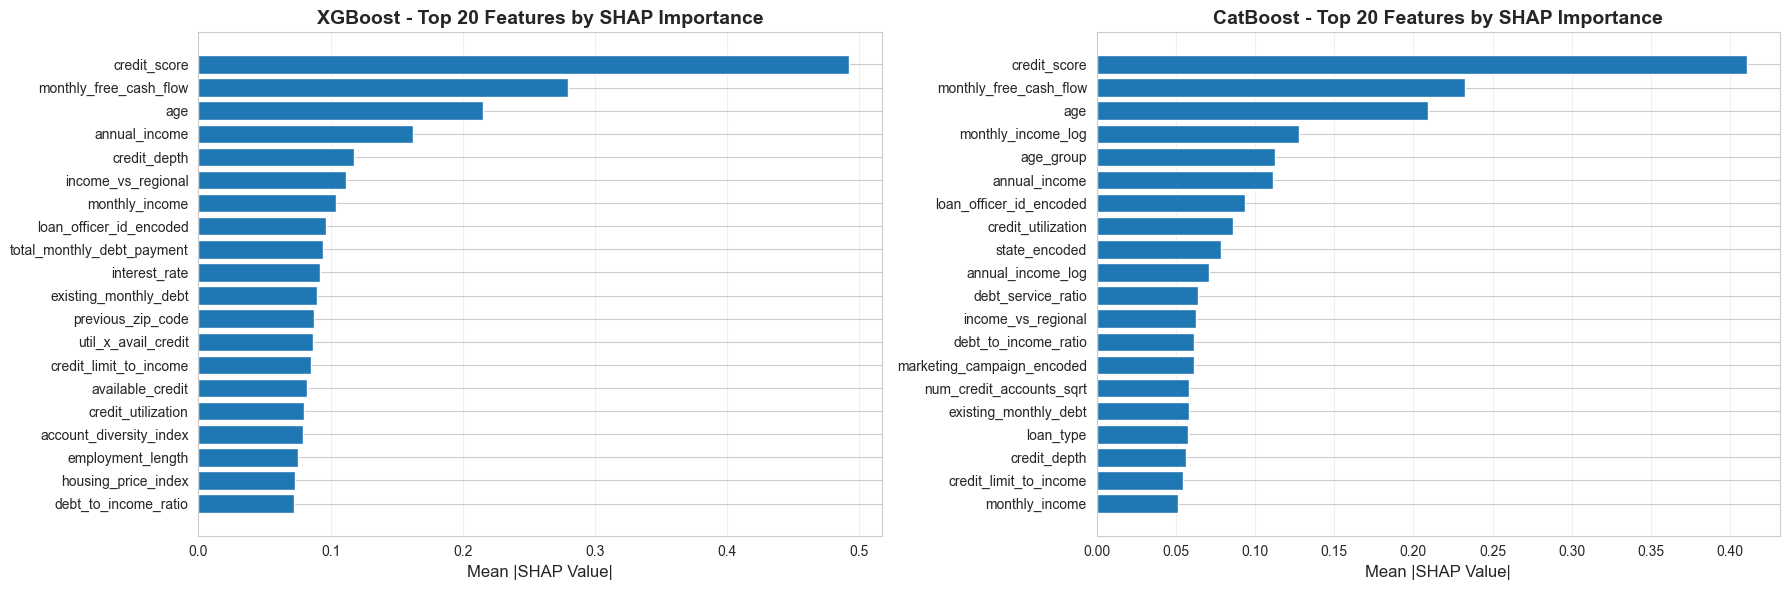


--- SHAP Summary Plot for XGBoost ---


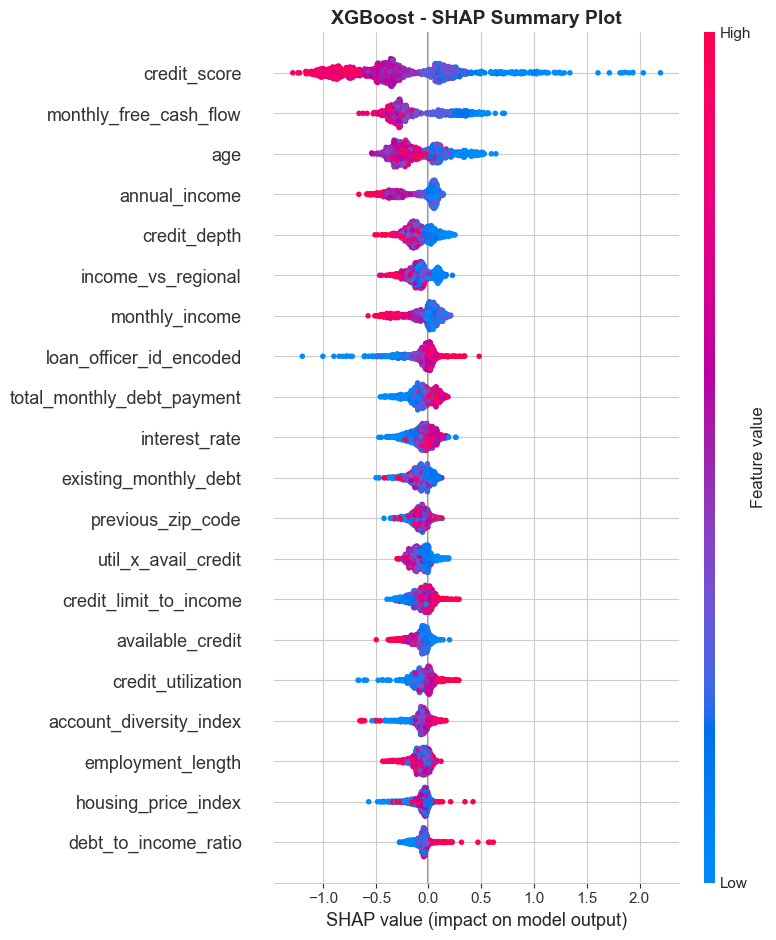


--- SHAP Summary Plot for CatBoost ---


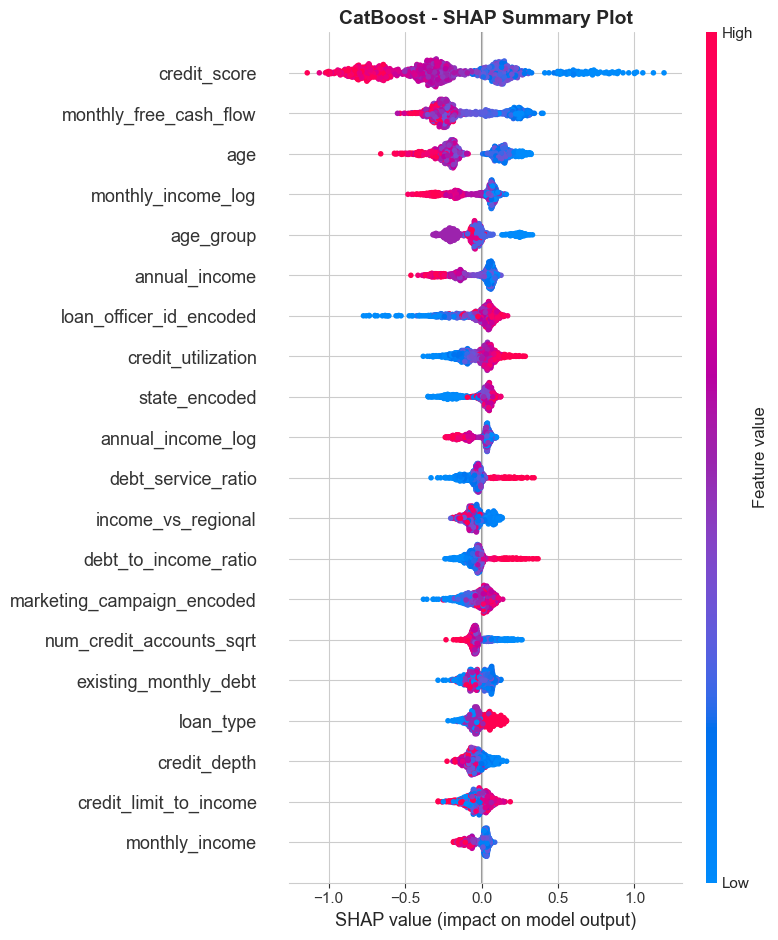


IDENTIFYING LOW IMPORTANCE FEATURES

Using best model (CatBoost) for feature selection
Importance threshold (10th percentile): 0.005742

Identified 11 low-importance features:
['has_referral', 'loan_term', 'has_delinquencies', 'num_delinquencies_2yrs_sqrt', 'debt_velocity', 'collection_to_accounts', 'has_recent_inquiries', 'is_late_night_application', 'referral_code', 'num_collections', 'account_tenure_ratio']

--- Feature Importance Statistics (CatBoost) ---
  Total features: 103
  Low importance features: 11
  Features to keep: 92
  Reduction: 10.7%

LOW IMPORTANCE FEATURES TO CONSIDER REMOVING
                    Feature  SHAP_Importance
               has_referral         0.005598
                  loan_term         0.005491
          has_delinquencies         0.005096
num_delinquencies_2yrs_sqrt         0.004680
              debt_velocity         0.002804
     collection_to_accounts         0.002513
       has_recent_inquiries         0.001529
  is_late_night_application        

In [13]:
import shap

# Initialize SHAP explainers for both models
shap_values_dict = {}
feature_importance_dict = {}

for name, model in models.items():
    print(f"\n--- Calculating SHAP values for {name} ---")
    
    # Use appropriate data for each model
    if name == 'CatBoost':
        X_shap = X_test  # Use unscaled data for CatBoost
    else:
        X_shap = X_test_scaled  # Use scaled data for XGBoost
    
    explainer = shap.TreeExplainer(model)
    
    # Calculate SHAP values (use a sample if dataset is large)
    sample_size = min(1000, len(X_shap))
    X_shap_sample = X_shap.sample(n=sample_size, random_state=42)
    
    shap_values = explainer.shap_values(X_shap_sample)
    shap_values_dict[name] = shap_values
    
    # Calculate mean absolute SHAP values for feature importance
    if isinstance(shap_values, list):  # For binary classification, some models return list
        shap_values_for_importance = shap_values[1]
    else:
        shap_values_for_importance = shap_values
    
    mean_shap = np.abs(shap_values_for_importance).mean(axis=0)
    
    # Create feature importance dataframe
    feature_importance = pd.DataFrame({
        'Feature': X_shap.columns,
        'SHAP_Importance': mean_shap
    }).sort_values('SHAP_Importance', ascending=False)
    
    feature_importance_dict[name] = feature_importance
    
    print(f"  ✓ SHAP values calculated for {sample_size} samples")
    print(f"\nTop 10 Most Important Features ({name}):")
    print(feature_importance.head(10).to_string(index=False))

# Visualize SHAP importance for both models
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

for idx, (name, feature_imp) in enumerate(feature_importance_dict.items()):
    top_n = 20
    top_features = feature_imp.head(top_n)
    
    axes[idx].barh(range(len(top_features)), top_features['SHAP_Importance'])
    axes[idx].set_yticks(range(len(top_features)))
    axes[idx].set_yticklabels(top_features['Feature'])
    axes[idx].invert_yaxis()
    axes[idx].set_xlabel('Mean |SHAP Value|', fontsize=12)
    axes[idx].set_title(f'{name} - Top {top_n} Features by SHAP Importance', 
                        fontsize=14, fontweight='bold')
    axes[idx].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# SHAP Summary plots
for name, model in models.items():
    print(f"\n--- SHAP Summary Plot for {name} ---")
    
    # Use appropriate data
    if name == 'CatBoost':
        X_shap = X_test.sample(n=min(1000, len(X_test)), random_state=42)
    else:
        X_shap = X_test_scaled.sample(n=min(1000, len(X_test_scaled)), random_state=42)
    
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_shap)
    
    if isinstance(shap_values, list):
        shap_values = shap_values[1]
    
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_shap, show=False, max_display=20)
    plt.title(f'{name} - SHAP Summary Plot', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("\n" + "="*80)
print("IDENTIFYING LOW IMPORTANCE FEATURES")
print("="*80)

# Get the best model from threshold optimization results
best_threshold_result = threshold_df.iloc[0]
best_model_name = best_threshold_result['Model']
best_model_importance = feature_importance_dict[best_model_name]

print(f"\nUsing best model ({best_model_name}) for feature selection")

# Set threshold for low importance (e.g., bottom 10% or features with very low SHAP)
importance_threshold = best_model_importance['SHAP_Importance'].quantile(0.10)  # Bottom 10%

low_importance_features = best_model_importance[
    best_model_importance['SHAP_Importance'] < importance_threshold
]['Feature'].tolist()

print(f"Importance threshold (10th percentile): {importance_threshold:.6f}")
print(f"\nIdentified {len(low_importance_features)} low-importance features:")
print(low_importance_features)

# Show statistics
print(f"\n--- Feature Importance Statistics ({best_model_name}) ---")
print(f"  Total features: {len(best_model_importance)}")
print(f"  Low importance features: {len(low_importance_features)}")
print(f"  Features to keep: {len(best_model_importance) - len(low_importance_features)}")
print(f"  Reduction: {len(low_importance_features)/len(best_model_importance)*100:.1f}%")

print("\n" + "="*80)
print("LOW IMPORTANCE FEATURES TO CONSIDER REMOVING")
print("="*80)
print(best_model_importance[best_model_importance['SHAP_Importance'] < importance_threshold].to_string(index=False))

## 11. RETRAINING WITH SELECTED FEATURES

In [14]:
print("\n" + "="*80)
print("RETRAINING MODELS WITH SELECTED FEATURES")
print("="*80)

# Remove low importance features
features_to_keep = [f for f in X_train.columns if f not in low_importance_features]
print(f"\nKeeping {len(features_to_keep)} out of {len(X_train.columns)} features")

# Create new datasets without low-importance features
X_train_selected = X_train[features_to_keep]
X_test_selected = X_test[features_to_keep]

# Scale the selected features
scaler_selected = StandardScaler()
X_train_selected_scaled = pd.DataFrame(
    scaler_selected.fit_transform(X_train_selected),
    columns=features_to_keep
)
X_test_selected_scaled = pd.DataFrame(
    scaler_selected.transform(X_test_selected),
    columns=features_to_keep
)

# Update categorical feature indices for CatBoost
cat_feature_indices_selected = [
    X_train_selected.columns.get_loc(col) 
    for col in categorical_cols 
    if col in X_train_selected.columns
]

print(f"Updated categorical features: {len(cat_feature_indices_selected)}")

# Retrain models
models_selected = {}

# XGBoost with selected features
print("\n[1/2] Retraining XGBoost with selected features...")
xgb_selected = xgb.XGBClassifier(
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=8,
    min_child_weight=10,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    gamma=1,
    random_state=42,
    tree_method='gpu_hist',
    eval_metric='auc'
)
xgb_selected.fit(X_train_selected_scaled, y_train)
models_selected['XGBoost'] = xgb_selected
print("  ✓ Complete")

# CatBoost with selected features
print("\n[2/2] Retraining CatBoost with selected features...")
cat_selected = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=8,
    l2_leaf_reg=5,
    min_data_in_leaf=20,
    border_count=128,
    auto_class_weights='Balanced',
    cat_features=cat_feature_indices_selected,
    task_type='GPU',
    random_state=42,
    verbose=0
)
cat_selected.fit(X_train_selected, y_train)
models_selected['CatBoost'] = cat_selected
print("  ✓ Complete")

# Evaluate retrained models
print("\n" + "="*80)
print("EVALUATING MODELS WITH SELECTED FEATURES")
print("="*80)

results_selected = []
for name, model in models_selected.items():
    print(f"\n--- Evaluating {name} (Selected Features) ---")
    
    # Use appropriate data
    if name == 'CatBoost':
        X_eval = X_test_selected
    else:
        X_eval = X_test_selected_scaled
    
    y_pred = model.predict(X_eval)
    y_pred_proba = model.predict_proba(X_eval)[:, 1]
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  ROC-AUC:   {roc_auc:.4f}")
    
    results_selected.append({
        'Model': name,
        'Features': 'Selected',
        'Num_Features': len(features_to_keep),
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    })


RETRAINING MODELS WITH SELECTED FEATURES

Keeping 92 out of 103 features
Updated categorical features: 13

[1/2] Retraining XGBoost with selected features...
  ✓ Complete

[2/2] Retraining CatBoost with selected features...
  ✓ Complete

EVALUATING MODELS WITH SELECTED FEATURES

--- Evaluating XGBoost (Selected Features) ---
  Accuracy:  0.9257
  Precision: 0.2825
  Recall:    0.2960
  F1-Score:  0.2891
  ROC-AUC:   0.7863

--- Evaluating CatBoost (Selected Features) ---
  Accuracy:  0.8888
  Precision: 0.2160
  Recall:    0.4483
  F1-Score:  0.2916
  ROC-AUC:   0.7960



THRESHOLD OPTIMIZATION FOR SELECTED FEATURES MODELS

Optimizing threshold for XGBoost...
  Optimal Threshold: 0.410
  F1-Score: 0.3017
  Precision: 0.2537
  Recall: 0.3721

Optimizing threshold for CatBoost...
  Optimal Threshold: 0.550
  F1-Score: 0.2983
  Precision: 0.2362
  Recall: 0.4048

THRESHOLD OPTIMIZATION RESULTS
   Model  Optimal_Threshold  F1_Score  Precision   Recall  Accuracy
 XGBoost               0.41  0.301720   0.253709 0.372144  0.912056
CatBoost               0.55  0.298316   0.236190 0.404788  0.902778


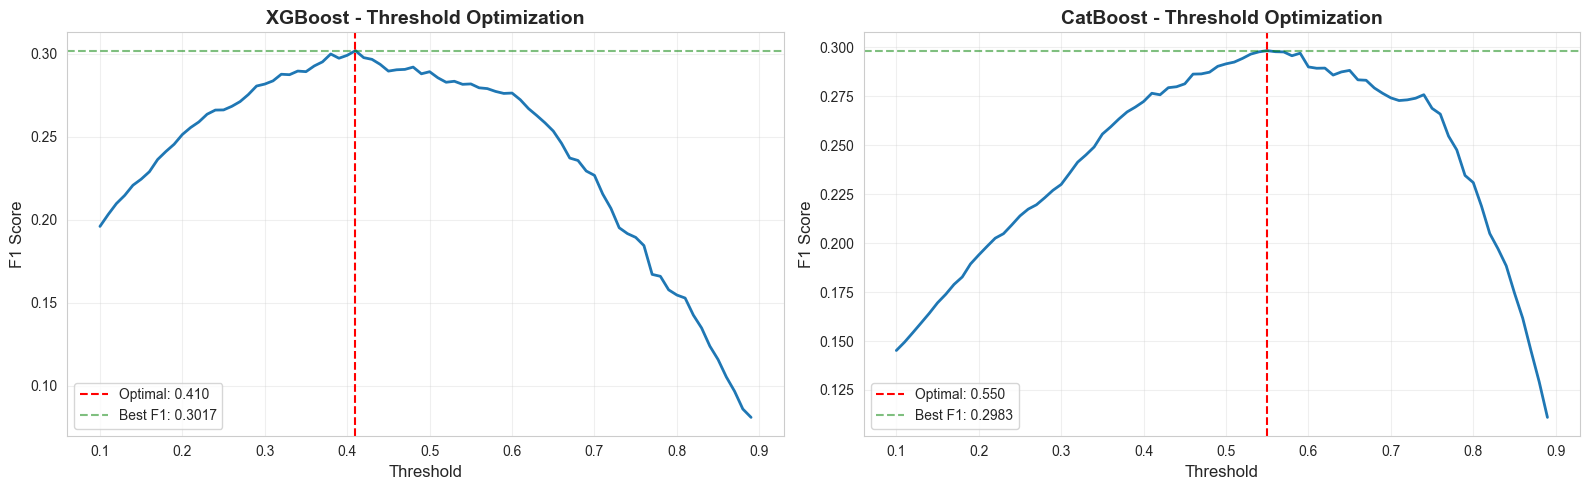


✓ Best model after threshold optimization: XGBoost
✓ Optimal threshold: 0.410
✓ F1 Score: 0.3017


In [15]:
print("\n" + "="*80)
print("THRESHOLD OPTIMIZATION FOR SELECTED FEATURES MODELS")
print("="*80)

threshold_results_selected = []
for name, model in models_selected.items():
    print(f"\nOptimizing threshold for {name}...")
    
    # Use appropriate data for each model
    if name == 'CatBoost':
        X_eval = X_test_selected  # CatBoost uses unscaled data
    else:
        X_eval = X_test_selected_scaled  # XGBoost uses scaled data
    
    result = find_optimal_threshold(model, X_eval, y_test, name)
    threshold_results_selected.append(result)
    
    print(f"  Optimal Threshold: {result['optimal_threshold']:.3f}")
    print(f"  F1-Score: {result['f1_score']:.4f}")
    print(f"  Precision: {result['precision']:.4f}")
    print(f"  Recall: {result['recall']:.4f}")

# Results table
threshold_df_selected = pd.DataFrame([{
    'Model': r['model'],
    'Optimal_Threshold': r['optimal_threshold'],
    'F1_Score': r['f1_score'],
    'Precision': r['precision'],
    'Recall': r['recall'],
    'Accuracy': r['accuracy']
} for r in threshold_results_selected]).sort_values('F1_Score', ascending=False)

print("\n" + "="*80)
print("THRESHOLD OPTIMIZATION RESULTS")
print("="*80)
print(threshold_df_selected.to_string(index=False))

# Visualize threshold vs F1 score (for 2 models)
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

for idx, result in enumerate(threshold_results_selected):
    axes[idx].plot(result['thresholds'], result['f1_scores'], linewidth=2)
    axes[idx].axvline(result['optimal_threshold'], color='red', linestyle='--', 
                     label=f"Optimal: {result['optimal_threshold']:.3f}")
    axes[idx].axhline(result['f1_score'], color='green', linestyle='--', alpha=0.5,
                     label=f"Best F1: {result['f1_score']:.4f}")
    axes[idx].set_xlabel('Threshold', fontsize=12)
    axes[idx].set_ylabel('F1 Score', fontsize=12)
    axes[idx].set_title(f"{result['model']} - Threshold Optimization", fontsize=14, fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Store best model with optimal threshold
best_threshold_result_selected = threshold_df_selected.iloc[0]
best_model_optimized = models_selected[best_threshold_result_selected['Model']]
best_threshold = best_threshold_result_selected['Optimal_Threshold']

print(f"\n✓ Best model after threshold optimization: {best_threshold_result_selected['Model']}")
print(f"✓ Optimal threshold: {best_threshold:.3f}")
print(f"✓ F1 Score: {best_threshold_result_selected['F1_Score']:.4f}")

## 12. SAVE PIPELINE COMPONENTS

In [16]:
# Save preprocessor
with open('preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)
print("\n✓ Saved: preprocessor.pkl")

# Save scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("✓ Saved: scaler.pkl")

# Save label encoders
with open('label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)
print("✓ Saved: label_encoders.pkl")

# Save best model
with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)
print(f"✓ Saved: best_model.pkl ({best_model_name})")

# Save feature names
with open('feature_names.pkl', 'wb') as f:
    pickle.dump(X.columns.tolist(), f)
print("✓ Saved: feature_names.pkl")

print("\n" + "="*80)
print("PIPELINE COMPLETE!")
print("="*80)
print("\nAll components saved. You can now:")
print("1. Load these files to predict on new data")
print("2. Use the same preprocessing pipeline consistently")
print("3. Generate explanations for any prediction")


✓ Saved: preprocessor.pkl
✓ Saved: scaler.pkl
✓ Saved: label_encoders.pkl
✓ Saved: best_model.pkl (CatBoost)
✓ Saved: feature_names.pkl

PIPELINE COMPLETE!

All components saved. You can now:
1. Load these files to predict on new data
2. Use the same preprocessing pipeline consistently
3. Generate explanations for any prediction


## 13. EVALUATION SET PREDICTION

In [17]:
eval_folder = Path('evaluation_set')

# 1. Application metadata
eval_app = pd.read_csv(eval_folder / 'application_metadata.csv')
if 'customer_ref' in eval_app.columns:
    eval_app.rename(columns={'customer_ref': 'customer_id'}, inplace=True)

# 2. Demographics
eval_demo = pd.read_csv(eval_folder / 'demographics.csv')
if 'cust_id' in eval_demo.columns:
    eval_demo.rename(columns={
        'cust_id': 'customer_id',
        'employment_length': 'years_employed',
        'education': 'education_level',
        'num_dependents': 'dependents'
    }, inplace=True)

# 3. Credit history
eval_credit = pd.read_parquet(eval_folder / 'credit_history.parquet')
if 'customer_number' in eval_credit.columns:
    eval_credit.rename(columns={
        'customer_number': 'customer_id',
        'num_credit_accounts': 'existing_loans',
        'num_delinquencies_2yrs': 'delinquencies_last_2yrs'
    }, inplace=True)

# 4. Loan details
eval_loan = pd.read_excel(eval_folder / 'loan_details.xlsx')
if 'loan_type' in eval_loan.columns:
    eval_loan.rename(columns={'loan_type': 'product_type'}, inplace=True)

# 5. Financial ratios
eval_financial_records = []
with open(eval_folder / 'financial_ratios.jsonl', 'r') as f:
    for line in f:
        eval_financial_records.append(json.loads(line))
eval_financial = pd.DataFrame(eval_financial_records)
if 'cust_num' in eval_financial.columns:
    eval_financial.rename(columns={
        'cust_num': 'customer_id',
        'debt_to_income_ratio': 'debt_to_income'
    }, inplace=True)

# 6. Geographic data
tree = ET.parse(eval_folder / 'geographic_data.xml')
root = tree.getroot()
eval_geo_records = []
for customer in root.findall('customer'):
    record = {'customer_id': customer.find('id').text}
    for child in customer:
        if child.tag != 'id':
            record[child.tag] = child.text
    eval_geo_records.append(record)
eval_geo = pd.DataFrame(eval_geo_records)

# Clean customer_id
for df in [eval_app, eval_demo, eval_credit, eval_loan, eval_financial, eval_geo]:
    if 'customer_id' in df.columns:
        df['customer_id'] = df['customer_id'].astype(str).str.strip()

# Merge all evaluation data
df_eval = eval_app.copy()
df_eval = df_eval.merge(eval_demo, on='customer_id', how='left')
df_eval = df_eval.merge(eval_credit, on='customer_id', how='left')
df_eval = df_eval.merge(eval_loan, on='customer_id', how='left')
df_eval = df_eval.merge(eval_financial, on='customer_id', how='left')
df_eval = df_eval.merge(eval_geo, on='customer_id', how='left')

# Store customer IDs for final output
eval_customer_ids = df_eval['customer_id'].copy()

In [18]:
# Transform using fitted preprocessor
test_processed = preprocessor.transform(df_eval, target_col='default', is_train=False)

# Prepare features
test_ids = test_processed['customer_id'].copy()
X_test_new = test_processed.drop(columns=['customer_id', 'application_id', 'default'], errors='ignore')

# Encode categoricals using saved encoders
for col in categorical_cols:
    if col in X_test_new.columns:
        le = label_encoders[col]
        X_test_new[col] = X_test_new[col].astype(str)
        
        # Map unknown categories to the first class (most common in training)
        known_classes = set(le.classes_)
        X_test_new[col] = X_test_new[col].apply(
            lambda x: x if x in known_classes else le.classes_[0]
        )
        X_test_new[col] = le.transform(X_test_new[col])

# Align columns with ORIGINAL feature set first
for col in X.columns:
    if col not in X_test_new.columns:
        X_test_new[col] = 0
X_test_new = X_test_new[X.columns]

# SELECT ONLY THE FEATURES USED IN TRAINING
X_test_new_selected = X_test_new[features_to_keep]
print(f"Selected {len(features_to_keep)} features from {len(X.columns)} total features")

# Handle missing/inf
X_test_new_selected = X_test_new_selected.fillna(0).replace([np.inf, -np.inf], 0)

# Scale using the scaler fitted on SELECTED features
X_test_new_selected_scaled = pd.DataFrame(
    scaler_selected.transform(X_test_new_selected),
    columns=features_to_keep
)

print(f"✓ Evaluation set processed with selected features")
print(f"  Shape: {X_test_new_selected.shape}")


TRANSFORMING DATA WITH ENHANCED FEATURES (TEST)

[Critical] Dropping random_noise_1 column...
  ✓ Removed planted noise column

[Step 1] Cleaning data...

[Step 2] Imputing categorical features...

[Step 3] Imputing numerical features...

[Step 4] Creating referral_code binary feature...
  ✓ Created 'has_referral' binary feature (1=referred, 0=REF0000)

[Step 5] Creating application timing features...
  ✓ Created is_night_application, is_late_night_application, cyclical encoding

[Step 7] Applying target encoding to business metadata...
  ✓ Target-encoded loan_officer_id
  ✓ Target-encoded marketing_campaign
  ✓ Target-encoded origination_channel
  ✓ Target-encoded state
  ✓ Target-encoded loan_purpose
  ✓ Target-encoded employment_type

[Step 8] Creating credit behavior × financial capacity interactions...
  ✓ Created 4 credit behavior × financial capacity features

[Step 9] Creating loan characteristics × customer profile interactions...
  ✓ Created 4 loan characteristics × customer

In [19]:
# Determine which data to use based on best model
best_model_name = best_threshold_result_selected['Model']
if best_model_name == 'CatBoost':
    X_eval_new = X_test_new_selected  # CatBoost uses unscaled data
    print(f"Using unscaled data for {best_model_name}")
else:
    X_eval_new = X_test_new_selected_scaled  # XGBoost uses scaled data
    print(f"Using scaled data for {best_model_name}")

# Get prediction probabilities from the best model
eval_proba = best_model_optimized.predict_proba(X_eval_new)[:, 1]

# Apply the optimal threshold
eval_predictions = (eval_proba >= best_threshold).astype(int)

print(f"Generated {len(eval_predictions)} predictions")
print(f"\nPrediction Statistics:")
print(f"  Total records: {len(eval_predictions)}")
print(f"  Predicted defaults: {eval_predictions.sum()}")
print(f"  Default rate: {eval_predictions.mean()*100:.2f}%")
print(f"  Average probability: {eval_proba.mean():.4f}")
print(f"  Min probability: {eval_proba.min():.4f}")
print(f"  Max probability: {eval_proba.max():.4f}")
print(f"\nOptimal threshold used: {best_threshold:.3f}")
print(f"Number of features used: {len(features_to_keep)}")

Using scaled data for XGBoost
Generated 10001 predictions

Prediction Statistics:
  Total records: 10001
  Predicted defaults: 352
  Default rate: 3.52%
  Average probability: 0.0718
  Min probability: 0.0003
  Max probability: 0.9134

Optimal threshold used: 0.410
Number of features used: 92


In [20]:
# Create results DataFrame
results_df = pd.DataFrame({
    'customer_id': eval_customer_ids,
    'prob': eval_proba,
    'default': eval_predictions
})

# Save to CSV in evaluation_set folder
output_file = 'evaluation_set/results.csv'
results_df.to_csv(output_file, index=False)

print(f"Results saved to: {output_file}")
print(f"\nResults preview:")
print(results_df.head(20))

print("\n" + "="*80)
print("EVALUATION PREDICTION COMPLETE!")
print("="*80)

Results saved to: evaluation_set/results.csv

Results preview:
   customer_id      prob  default
0       100000  0.015437        0
1       100001  0.021366        0
2       100002  0.161764        0
3       100003  0.050070        0
4       100004  0.092814        0
5       100005  0.030581        0
6       100006  0.009033        0
7       100007  0.077242        0
8       100008  0.001382        0
9       100009  0.016397        0
10      100010  0.005963        0
11      100011  0.004114        0
12      100012  0.045278        0
13      100013  0.003204        0
14      100014  0.018589        0
15      100015  0.023741        0
16      100016  0.045218        0
17      100017  0.004014        0
18      100018  0.218781        0
19      100019  0.015799        0

EVALUATION PREDICTION COMPLETE!
